# Introduction to Embeddings and RAG

This notebook provides a concise introduction to text embeddings, retrieval, and retrieval-augmented generation (RAG). It serves as a foundation for the main focus of our workshop: **Synthetic Data Generation for Embedding Model Fine-Tuning**.

Regardless of your experience level with these concepts, this introduction will equip you with the essential knowledge needed for the hands-on exercises that follow. If you're new to the topic, don't worry if some details seem complex at first—you'll still be able to follow along with the workshop's core activities.

By the end of this notebook, you'll understand the fundamental concepts that underpin our work with synthetic data generation and embedding model fine-tuning.

## Setup

> ***Important:*** *As we won't need it in this notebook and usage is limited, make sure you are* ***not*** *using a GPU runtime. Click on `Runtime` > `Change runtime type` > Select `CPU` and Save.*

> *Also, to make sure there are no older sessions running, click on `Runtime` > `Manage sessions` > `Terminate other sessions`*

During the whole workshop, we will use *Gemini-2.0-Flash* as LLM of our choice. If you haven't already tested the setup before the workshop, go to https://aistudio.google.com/, log in with your Google account and click "Create API Key". This gives you a access to 1500 requests per day at 15 RPM, which is perfectly fine for our purposes.

*Warning: When using the free version of Gemini, Google can use your interactions to improve their products and models, so don't use it for any sensitive or work-related data.*

When you have your key, you can use one of the following options to make it accessible from this notebook:
1. Add the key to Google Colab's `Secrets`. You can even import it directly by clicking on `Gemini API Keys -> Import key from Google AI Studio`. Make sure `Notebook access` is enabled. That's the easiest and recommended way.
2. The other way would be to copy-paste it into this notebook and add it to the environment with `os`



In [ ]:
import os
from typing import Dict, Any, Optional, List
from google import genai
from google.colab import userdata
from google.genai import types
from IPython.display import display, Markdown


os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")  # alternatively paste your key here
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

We define two helper functions `generate_text` and `embed_text` so that we quickly and conveniently can call the Gemini text generation and embedding endpoints

In [ ]:
def generate_text(
    prompt: str,
    model: str = "gemini-2.0-flash",
    temperature: Optional[float] = None,
    max_tokens: Optional[int] = None,
    system_instructions: Optional[str] = None
) -> str:
    """
    Generate text using Google's Gemini model with configurable parameters.

    Args:
        prompt: The user prompt to send to the model
        model: Model name to use (default: gemini-2.0-flash)
        temperature: Controls temperature (0.0-2.0, lower is more deterministic)
        max_tokens: Maximum number of tokens to generate
        system_instructions: Optional system instruction to guide the model

    Returns:
        Generated text response as string
    """
    try:
        # Create config with only non-None parameters
        config_params = {}
        if temperature:
            config_params["temperature"] = temperature
        if max_tokens is not None:
            config_params["max_output_tokens"] = max_tokens
        if system_instructions:
            config_params["system_instruction"] = system_instructions

        # Create the config object
        config = types.GenerateContentConfig(**config_params)

        # Generate content
        response = client.models.generate_content(
            model=model,
            contents=[prompt],
            config=config
        )

        return response.text
    except Exception as e:
        return f"Error generating text: {str(e)}"

def embed_text(
    text: str,
    model: str = "text-embedding-004"
) -> List[float]:
    """
    Generate embeddings for a text string using Google's embedding model.

    Args:
        text: The text to generate embeddings for
        model: Embedding model to use (default: text-embedding-004)

    Returns:
        List of embedding values as floats
    """
    try:
        # Generate embeddings
        response = client.models.embed_content(
            model=model,
            contents=[text]
        )

        # Return the embedding values
        return response.embeddings[0].values
    except Exception as e:
        print(f"Error generating embedding: {str(e)}")
        return []

## Part 1 - Case study: EU AI Act

Imagine this hypothetical scenario: You work as a Machine Learning Engineer at a hot new startup which builds AI solutions in the legal domain. You were tasked to build the model for a new system that should help users of any kind (lawyers, journalists, policy makers, companies..) answer questions about the EU's Artificial Intelligence Act (or short, AI Act): https://en.wikipedia.org/wiki/Artificial_Intelligence_Act

If you need a quick refresher yourself, the AI Act is a comprehensive regulation establishing a common legal framework for artificial intelligence within the EU. It aims to ensure that AI systems used within the EU are safe, transparent, and respect fundamental rights. The Act came into force on August 1, 2024, with its provisions being implemented gradually over the following 6 to 36 months.

For your model to be a considered success, it needs to:
1. accurately answer the user's questions
2. be based on the latest and official version of the AI Act
3. be able to directly copy passages from the regulatory text
4. to provide references to specific sections and articles

One potential client of your new system sent you an example question that they, as a security department at a large enterprise working on AI models, have: *'How does the reach of a general-purpose AI model to thousands of business users in the EU affect its classification as having systemic risk?'*

With LLMs recently getting better and better at generating text you're thinking to try out the easist way first, simply throwing the question into an LLM and see how well it answers the question. Let's go ahead and do that

In [ ]:
query = "How does the reach of a general-purpose AI model to thousands of business users in the EU affect its classification as having systemic risk?"

In [ ]:
answer = generate_text(query, system_instructions="Your task is to answer questions about the EU AI Act as accurately and concisely as possible.")
display(Markdown(answer))

The EU AI Act doesn't directly classify AI models as "systemic risk" based solely on the number of business users in the EU. Instead, it focuses on classifying *general-purpose AI models* (GPAI) with *systemic risk*. The reach to thousands of business users is **one factor** that contributes to the assessment of whether a GPAI model poses systemic risk, but it's not the only one, and it's not a definitive threshold.

Here's a more detailed breakdown:

*   **Systemic Risk:**  Under the AI Act, GPAI models are classified as having systemic risk if they pose a significant risk to security, health, fundamental rights, society, democracy or the rule of law. This is a high bar, suggesting broad and potentially destabilizing impact.

*   **Reach (and capabilities) as indicators:**  A large number of business users amplifies the *potential* impact of a GPAI model. If a model is used extensively by many businesses in the EU, any vulnerabilities, biases, or failures in the model could have widespread consequences.  This *reach* is considered *in conjunction with* the model's *capabilities* and the sectors using it. A model with limited capabilities, even with many users, might not be classified as systemic risk.

*   **Specific criteria for GPAI with systemic risk** The AI Act (specifically Article 52a) requires the European Commission to develop criteria for determining systemic risk for GPAI models.  These criteria *will* likely include factors related to the model's size, complexity, capabilities (including tasks it can perform), *number of business users*, autonomy, and the extent of its use.

*   **Other Factors:** Besides the number of users, other considerations include:
    *   The *criticality* of the sectors using the model (e.g., healthcare, finance).
    *   The model's ability to generate outputs that could be misused (e.g., deepfakes, disinformation).
    *   The potential for the model to be used in ways that violate fundamental rights.
    *   The model's computational resources required to train and run it.
    *   Number of parameters (as a proxy for model complexity and capabilities).

**In summary:** A large reach to thousands of business users in the EU increases the *likelihood* that a GPAI model will be considered to have systemic risk, especially if coupled with significant capabilities, use in critical sectors, or potential for misuse. However, it is not a guaranteed trigger. The final classification depends on a comprehensive assessment based on criteria established by the European Commission. The EU AI Office will also play a key role in this assessment.


Alright, this answer sounds pretty good. But let's see if it is actually correct.

In [ ]:
passage = """ANNEX XIII

Criteria for the designation of general-purpose AI models with systemic risk referred to in Article 51
For the purpose of determining that a general-purpose AI model has capabilities or an impact equivalent to those set out in Article 51(1), point (a), the Commission shall take into account the following criteria:
(a) the number of parameters of the model;
(b) the quality or size of the data set, for example measured through tokens;
(c) the amount of computation used for training the model, measured in floating point operations or indicated by a combination of other variables such as estimated cost of training, estimated time required for the training, or estimated energy consumption for the training;
(d) the input and output modalities of the model, such as text to text (large language models), text to image, multi-modality, and the state of the art thresholds for determining high-impact capabilities for each modality, and the specific type of inputs and outputs (e.g. biological sequences);
(e) the benchmarks and evaluations of capabilities of the model, including considering the number of tasks without additional training, adaptability to learn new, distinct tasks, its level of autonomy and scalability, the tools it has access to;
(f) whether it has a high impact on the internal market due to its reach, which shall be presumed when it has been made available to at least 10 000 registered business users established in the Union;
(g) the number of registered end-users."""

In [ ]:
prompt = f"""You are a professional fact-checker and your task is to check the accuracy of an answer to a question. The accuracy of the answer should be assessed based on a provided passage from the EU AI Act.

## Question:
{query}

## Passage:
{passage}

## Answer:
{answer}

Point out any discrepancies you can find. Be thorough in your assessment and provide a concise answer."""

In [ ]:
display(Markdown(generate_text(prompt)))

The answer contains a few inaccuracies:

1.  **Misinterpretation of Annex XIII(f):** The answer states that "the number of users is not the *sole* deciding factor, the Commission can take into account the 'number of business users' as an *indicator* when assessing if a GPAI model poses systemic risk". This is incorrect. Annex XIII(f) explicitly states that a high impact on the internal market "shall be presumed when it has been made available to at least 10 000 registered business users established in the Union." This is not merely an indicator; it's a specific threshold that, when met, creates a presumption of high impact and thus contributes to the classification of systemic risk. The answer downplays the significance of this specific threshold. The answer should emphasize that 10,000 registered business users is a *trigger* for presumed high impact.

2.  **Incorrect citation:** The reference to (Article 52a.1.b) is incorrect. The provided passage is from Annex XIII, which directly relates to Article 51.



So while the answer is actually quite good, it is not 100% accurate, which is a problem for your customers as they require an extremely high degree of reliability from your system.

Also, remember that they want the model to quote from the regulartory text.

In [ ]:
system_prompt = """Your task is to answer questions about the EU AI Act as accurately and concisely as possible.

In addition to your answer, provide:
- a direct quote of relevant sentences and
- mention in which part (section, article, paragraph) of the regulatory framework the sentence appeared."""

answer = generate_text(query, system_instructions=system_prompt)
display(Markdown(answer))

The EU AI Act doesn't explicitly define a threshold for the number of business users in the EU that would automatically qualify a general-purpose AI model as posing a systemic risk. However, it indicates that the Commission may designate a general-purpose AI model as having systemic risk based on several criteria, including the number of business users.

Specifically, Article 52b(1) states that a general-purpose AI model can be designated as having systemic risk if it has a high impact, based on criteria that include the number of business users.

Quote:
"A general-purpose AI model may be designated as having systemic risk where it meets at least one of the following criteria: (a) it has a high impact, based on criteria such as the model size, the amount of compute used for its training, the number of business users"
(EU AI Act, Article 52b, paragraph 1)


Now we have a problem. It seems like the model just entirely made this quote and article up.

That's not the model's fault, as it has been a) optimized to be extremely helpful, so it even tries to "help" you when it can't and b) it doesn't know what it doesn't know.

The risky thing here is that is sounds like the model knows what it's talking about and it generally even has a good grasp on the AI Act. However, for applications that require very high accuracy and reliablity, just asking an LLM for an answer is *simply not a good solution*.

In [ ]:
system_prompt = f"""Your task is to answer questions about the EU AI Act as accurately and concisely as possible.

In addition to your answer, provide:
- a direct quote of relevant sentences and
- mention in which part (section, article, paragraph) of the regulatory framework the sentence appeared.

Answer the question based on the following context:
{passage}"""

answer = generate_text(query, system_instructions=system_prompt)
display(Markdown(answer))

If a general-purpose AI model has been made available to at least 10,000 registered business users established in the Union, it is presumed to have a high impact on the internal market, which is a criterion the Commission considers when determining whether the model has capabilities or an impact equivalent to those set out in Article 51(1), point (a) concerning systemic risk.

"whether it has a high impact on the internal market due to its reach, which shall be presumed when it has been made available to at least 10 000 registered business users established in the Union" (ANNEX XIII, (f)).


Based on the passage, the model can now easily answer the question, quote a sentence from the passage and provide a reference for double-checking.

As you can see ***RAG is all about providing the right context to your LLM at the right time***

Here we cheated of course, as we knew in advance which passage to provide to the model. In real life however, we need to find the right context out of a whole corpus of texts. And we need to be able to do that in a dynamic and efficient way.

That brings us to the next part and main focus of this workshop: *How do we find the right context given a query?*

## Part 2 - Embeddings

### What are Text Embeddings?

Text embeddings are numerical representations of text in a high-dimensional vector space. They capture semantic meaning in a way that computers can process mathematically.

Think of embeddings as translating words or sentences into a list of numbers (typically hundreds or thousands of dimensions) where:
- Similar texts are positioned close together in this space
- Dissimilar texts are positioned far apart
- The relationships between concepts are preserved

We will start by embedding our query and passage into numerical vectors using the Gemini embedding API

In [ ]:
query_vec = embed_text(query)
passage_vec = embed_text(passage)

In [ ]:
len(query), len(query_vec)

(140, 768)

In [ ]:
len(passage), len(passage_vec)

(1505, 768)

In [ ]:
print(query_vec[:10])

[0.0027335663, 0.024754701, -0.01819174, 0.01737428, -0.03445709, 0.04811883, 0.11105131, -0.051420912, -0.018992785, 0.03047424]


In [ ]:
print(passage_vec[:10])

[0.0073675825, 0.054946616, -0.022156317, 0.00898344, -0.005389736, 0.055260193, 0.063372605, -0.03645704, 0.0068883826, -0.008613096]


The Gemini embeddings converted each input text into a 768-dimensional vector of values which we can use for all kinds of mathematical operations.

Let's first embed another unrelated sentence.

In [ ]:
passage2 = "Prague is home to the world's oldest functioning astronomical clock, the Prague Orloj, which was installed in 1410. It is the third-oldest astronomical clock in the world and the oldest one still in operation. Every hour, a small show takes place where mechanical figures, including the Twelve Apostles, emerge and move around the clock!"
passage2_vec = embed_text(passage2)

### Calculating Distance Between Embeddings

To determine how semantically similar two texts are, we need to calculate the distance between their embedding vectors. The most common similarity measure for embeddings is **cosine similarity**.

Cosine similarity measures the cosine of the angle between two vectors, effectively comparing their orientations rather than magnitudes. The formula is:

$$\text{cosine_similarity}(A, B) = \frac{A \cdot B}{||A|| \: ||B||} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \: \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Where:
- $A \cdot B$ is the dot product of vectors A and B
- $||A||$ and $||B||$ are the magnitudes (L2 norms) of vectors A and B

The result ranges from -1 (completely opposite) to 1 (exactly the same), with 0 indicating orthogonality (no similarity).

Let's implement this from scratch using NumPy to understand what's happening under the hood:

In [ ]:
import numpy as np

# Convert vectors to numpy arrays if they aren't already
vec_a = np.array(query_vec)
vec_b = np.array(passage_vec)

In [ ]:
# Step 1: Calculate dot product (numerator)
dot_product = np.dot(vec_a, vec_b)
print(f"Dot product: {dot_product}")

Dot product: 0.792150432453375


The dot product measures similarity between vectors by calculating how much they point in the same direction.

Geometrically, the dot product is defined as:
A·B = |A|×|B|×cos(θ)

Where:
- |A| and |B| are the magnitudes of the vectors
- θ is the angle between them
- cos(θ) ranges from -1 (opposite directions) to 1 (same direction)

When vectors point in similar directions, their dot product is larger. When they're perpendicular, it's zero. When they point in opposite directions, it's negative.

For embedding vectors specifically, a higher dot product suggests the texts share similar semantic meaning. However, the raw dot product is affected by vector magnitudes, which is why we normalize it in cosine similarity to focus purely on direction.

In [ ]:
# Step 2: Calculate L2 norms (magnitudes) of both vectors
norm_a = np.linalg.norm(vec_a)
norm_b = np.linalg.norm(vec_b)
print(f"Norm of vector A: {norm_a}")
print(f"Norm of vector B: {norm_b}")

Norm of vector A: 0.9999982143440607
Norm of vector B: 0.999952794888602


The magnitude (or norm) of a vector represents its "length" in the vector space. For embedding vectors:

- The magnitude tells us how "strong" the signal is in the embedding space
- Most embedding models normalize their outputs to have a magnitude close to 1.0 (unit vectors)
- This normalization makes comparing vectors more consistent, focusing on direction rather than magnitude

In our example, both vectors have magnitudes very close to 1.0 (0.999...), which indicates they've been normalized by the embedding model. This is typical for modern embedding systems as it simplifies similarity calculations.

In [ ]:
# Step 3: Calculate cosine similarity
similarity = dot_product / (norm_a * norm_b)
print(f"Cosine similarity: {similarity}")

Cosine similarity: 0.7921892423454586


In [ ]:
def cosine_similarity(vec_a, vec_b):
    """
    Calculate the cosine similarity between two vectors.

    Args:
        vec_a: First vector (list or numpy array)
        vec_b: Second vector (list or numpy array)

    Returns:
        Cosine similarity score between -1 and 1
    """
    # Convert to numpy arrays if they aren't already
    vec_a = np.array(vec_a)
    vec_b = np.array(vec_b)

    # Calculate dot product
    dot_product = np.dot(vec_a, vec_b)

    # Calculate L2 norms (magnitudes)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)

    # Calculate cosine similarity
    similarity = dot_product / (norm_a * norm_b)

    return similarity.item()

In [ ]:
cosine_similarity(query_vec, passage2_vec)

0.2383258148671758

In [ ]:
cosine_similarity(passage_vec, passage2_vec)

0.30555290822587733

As we can see, the random passage about Prague is more distant from both our query and passage from the AI Act.

Let's try a more related passage about another regulatory topic (GDPR)

In [ ]:
passage3 = "The General Data Protection Regulation (Regulation (EU) 2016/679),[1] abbreviated GDPR, is a European Union regulation on information privacy in the European Union (EU) and the European Economic Area (EEA). The GDPR is an important component of EU privacy law and human rights law, in particular Article 8(1) of the Charter of Fundamental Rights of the European Union."
passage3_vec = embed_text(passage3)
cosine_similarity(query_vec, passage3_vec)

0.4828460631698464

We'll also check the similarity score of another passage from the AI Act.

In [ ]:
passage4 = """Chapter IX - POST-MARKET MONITORING, INFORMATION SHARING AND MARKET SURVEILLANCE

Section 5 - Supervision, investigation, enforcement and monitoring in respect of providers of general-purpose AI models

Article 92 - Power to conduct evaluations

5.   The providers of the general-purpose AI model concerned or its representative shall supply the information requested. In the case of legal persons, companies or firms, or where the provider has no legal personality, the persons authorised to represent them by law or by their statutes, shall provide the access requested on behalf of the provider of the general-purpose AI model concerned."""
passage4_vec = embed_text(passage4)
cosine_similarity(query_vec, passage4_vec)

0.6111680200064004

As we can see, the more related the documents are, the higher values of cosine similarity we observe.

### Visualization

To get a better understanding, we will also visualize the embeddings above in a two-dimensional space using dimensionality reduction so we can plot it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from sklearn.decomposition import PCA

In [ ]:
def visualize_embeddings(query_vec, passage_vecs, labels=None, title="Embedding Space Visualization"):
    """
    Visualize the distances between query and passages in 2D embedding space using sklearn's PCA.

    Args:
        query_vec: Embedding vector of the query (list or numpy array)
        passage_vecs: List of embedding vectors for passages
        labels: List of labels for the passages (default: None)
        title: Title for the plot

    Returns:
        List of similarities between query and passages
    """

    # Ensure all vectors are numpy arrays
    query_vec = np.array(query_vec)
    passage_vecs = [np.array(vec) for vec in passage_vecs]

    # Create default labels if none provided
    if labels is None:
        labels = [f"p{i+1}" for i in range(len(passage_vecs))]

    # Combine query and passages for dimensionality reduction
    all_vecs = np.vstack([query_vec] + passage_vecs)

    # Calculate cosine similarities between query and each passage
    similarities = [cosine_similarity(query_vec, vec) for vec in passage_vecs]

    # Reduce dimensionality to 2D using sklearn's PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(all_vecs)

    # Set up the plot
    plt.figure(figsize=(8, 6))  # Square figure

    # Plot passages
    passage_points = plt.scatter(
        vectors_2d[1:, 0],
        vectors_2d[1:, 1],
        c=similarities,
        cmap='viridis',
        s=100,
        alpha=0.8
    )

    # Plot query
    query_point = plt.scatter(
        vectors_2d[0, 0],
        vectors_2d[0, 1],
        c='red',
        s=150,
        marker='*',
        edgecolors='black'
    )

    # Add colorbar to show similarity scale
    cbar = plt.colorbar(passage_points)
    cbar.set_label('Cosine Similarity to Query')

    # Draw arrows from query to each passage
    for i in range(1, len(vectors_2d)):
        arrow = FancyArrowPatch(
            vectors_2d[0],
            vectors_2d[i],
            arrowstyle='->',
            alpha=0.3,
            mutation_scale=20
        )
        plt.gca().add_patch(arrow)

    # Add labels
    plt.annotate(
        "Query",
        vectors_2d[0] + np.array([0.05, -0.05]),
        fontsize=8,
    )

    # Add passage labels
    for i in range(len(labels)):
        plt.annotate(
            labels[i],
            vectors_2d[i+1] + np.array([0.05, 0.05]),
            fontsize=7,
        )

    plt.title(title, fontsize=11)
    plt.grid(alpha=0.3)

    # Set equal aspect ratio to ensure equal scaling
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Return the similarity scores
    return similarities


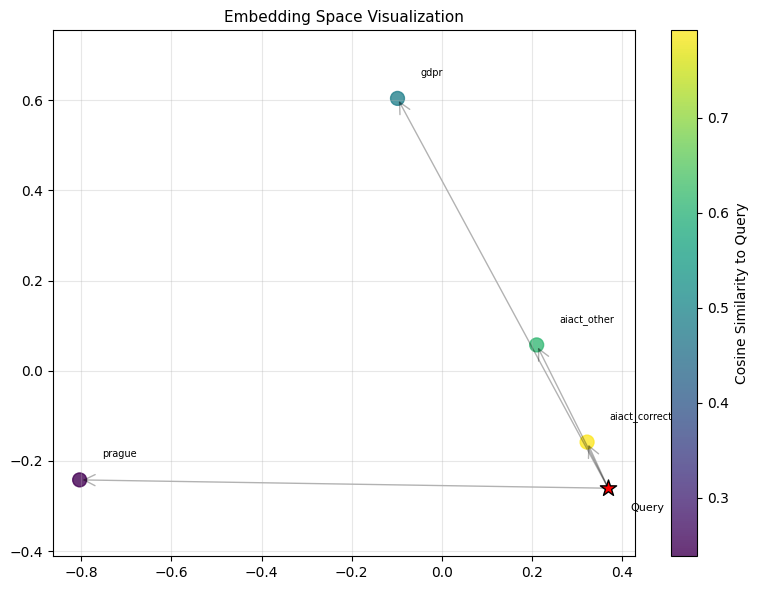

[0.7921892423454586,
 0.2383258148671758,
 0.4828460631698464,
 0.6111680200064004]

In [ ]:
visualize_embeddings(
    query_vec,
    [passage_vec, passage2_vec, passage3_vec, passage4_vec],
    ["aiact_correct", "prague", "gdpr", "aiact_other"]
)

This 2D visualization of our embedding space reveals some interesting insights:

1. **Directional Clustering**: Notice how all three regulatory passages (aiact_correct, gdpr, aiact_other) point in roughly the same general direction from the query, forming a regulatory "cluster" in the embedding space. This demonstrates how embeddings capture domain relationships - texts about regulations share semantic similarities even when discussing different specific regulations.

2. **Similarity Gradient**: The color intensity indicates cosine similarity to our query, with aiact_correct showing the strongest similarity (brightest yellow), followed by aiact_other (teal), then gdpr (darker blue). This aligns with our intuition - the passage specifically about GPAI systemic risk is most relevant to our query.

3. **Unrelated Content**: The passage about Prague points in a completely different direction with the lowest similarity score (darkest purple), confirming that embeddings effectively separate unrelated semantic concepts.

This visualization demonstrates why embedding-based retrieval works - relevant documents cluster in similar regions of the embedding space, allowing us to find semantically similar content even when the exact words don't match.

## Part 3: Evaluation

Next, we will learn how to evaluate text embedding or retrieval models given a query and a collection of documents.

We will pick a slighly more challenging question from our dataset which has two passages labeled as relevant.

In [ ]:
query = "Under what conditions does the AI Act exempt individual users from compliance when utilizing AI systems for personal, non-commercial purposes?"

In [ ]:
!wget -q "https://drive.google.com/uc?export=download&id=1kTbWY9JJf0fFoqZGh6d-DRHQel6sT-9Y" -O ./sample_data.csv

In [ ]:
import pandas as pd
df = pd.read_csv("sample_data.csv").iloc[:40]

In [ ]:
df.head()

,passage_id,passage,relevant
0,0,Chapter I - GENERAL PROVISIONS\n\nArticle 2 - ...,True
1,1,Preamble\n\n(13)The notion of ‘deployer’ refer...,True
2,2,ANNEX IV\n\n(b) the design specifications of t...,False
3,3,"Chapter IX - POST-MARKET MONITORING, INFORMATI...",False
4,4,"Chapter IX - POST-MARKET MONITORING, INFORMATI...",False


In [ ]:
passages = [(row.passage_id, row.passage) for row in df.itertuples(index=False)]

Passages 0 and 1 are relevant for `query`, all others are irrelevant.

In [ ]:
# prompt: group df by the value in column "relevant" and return counts
relevance_counts = df.groupby("relevant").size()
relevance_counts

,0
relevant,
False,38
True,2


Generally speaking we want to evaluate ***retrieval accuracy***. In other words, we want to find out how well a model is able to find relevant passages for a given query from a large collection of documents which can range from hundreds to millions.

The way we do this is the following:
1. embed query and all candidate documents
2. calculate cosine similarity between query and all candidate documents
3. rank documents by similarity score
4. calculate different metrics based on the ranking

We will start by implementing steps 1-3

In [ ]:
import time

In [ ]:
# Step 1: Embed query and all candidate documents
passage_embeddings = []
for idx, passage in passages:
    try:
        embedding = embed_text(passage)
        passage_embeddings.append(embedding)
        time.sleep(0.2)  # avoid overloading the API
    except Exception as e:
        passage_embeddings.append(e)
errors = [e for e in passage_embeddings if isinstance(e, Exception)]
print("Number of errors:", len(errors))

Number of errors: 0


In [ ]:
# Step 2: Calculate cosine similarity between query and all candidate documents
similarity_scores = []
for i, embedding in enumerate(passage_embeddings):
    score = cosine_similarity(query_vec, embedding)
    passage_idx = passages[i][0]
    similarity_scores.append((passage_idx, score))

In [ ]:
# Step 3: Rank documents by similarity score (descending order)
ranked_passages = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

In [ ]:
[(f"Rank {i+1}, ID {r[0]}, score {r[1]}" + (" (correct)" if r[0] in [0,1] else "")) for i,r in enumerate(ranked_passages)]

['Rank 1, ID 5, score 0.6739520268334639',
 'Rank 2, ID 34, score 0.6707132776723095',
 'Rank 3, ID 15, score 0.6500762916469087',
 'Rank 4, ID 1, score 0.6238556663323849 (correct)',
 'Rank 5, ID 8, score 0.6237972220467776',
 'Rank 6, ID 12, score 0.6211697034956017',
 'Rank 7, ID 23, score 0.6200020672548366',
 'Rank 8, ID 37, score 0.6117610868722156',
 'Rank 9, ID 11, score 0.6111680200064004',
 'Rank 10, ID 9, score 0.6012741568685558',
 'Rank 11, ID 28, score 0.5973483085578702',
 'Rank 12, ID 17, score 0.5967991271018954',
 'Rank 13, ID 18, score 0.596016884477643',
 'Rank 14, ID 10, score 0.5958525813014127',
 'Rank 15, ID 4, score 0.5932343922916654',
 'Rank 16, ID 35, score 0.5893697232521148',
 'Rank 17, ID 38, score 0.5878255910024963',
 'Rank 18, ID 2, score 0.5866692692235886',
 'Rank 19, ID 29, score 0.5836839290630129',
 'Rank 20, ID 25, score 0.5835719911334046',
 'Rank 21, ID 26, score 0.5779137176505105',
 'Rank 22, ID 22, score 0.5765438496061258',
 'Rank 23, ID 20

### Basic retrieval metrics

When evaluating embedding models for retrieval tasks, we use several metrics to measure performance from different angles. Each provides unique insights into how well our system finds relevant information.

**Accuracy@k**: Measures whether at least one relevant document appears in the top k results.
- Binary metric: 1 if at least one relevant document is in top k, 0 otherwise
- Simple but doesn't account for ranking position or multiple relevant documents
- Formula: 1 if any relevant document in top k, else 0

**Precision@k**: Measures the proportion of relevant documents among the top k retrieved documents.
- Formula: (Number of relevant documents in top k) / k
- Ranges from 0 to 1, with 1 meaning all top k documents are relevant
- Doesn't consider the ordering within the top k results

**Recall@k**: Measures what fraction of all relevant documents are found in the top k results.
- Formula: (Number of relevant documents in top k) / (Total number of relevant documents)
- Ranges from 0 to 1, with 1 meaning all relevant documents are in top k
- Important when you need to find all relevant information

In [ ]:
def basic_retrieval_metrics(ranked_passages, relevant_ids, k=10):
    """
    Calculate common retrieval metrics for a ranked list of passages.

    Args:
        ranked_passages: List of tuples (passage_id, score) sorted by score in descending order
        relevant_ids: List of IDs that are considered relevant for the query
        k: The cutoff point for calculating metrics (default: 10)

    Returns:
        Dictionary containing accuracy@k, precision@k, and recall@k
    """
    # Ensure k is not larger than the number of ranked passages
    k = min(k, len(ranked_passages))

    # Get the top k passage IDs
    top_k_ids = [passage_id for passage_id, _ in ranked_passages[:k]]

    # Count relevant documents in top k
    relevant_in_top_k = sum(1 for passage_id in top_k_ids if passage_id in relevant_ids)

    # Calculate metrics
    accuracy_at_k = 1 if relevant_in_top_k > 0 else 0
    precision_at_k = relevant_in_top_k / k if k > 0 else 0
    recall_at_k = relevant_in_top_k / len(relevant_ids) if relevant_ids else 0

    return {
        f"accuracy@{k}": accuracy_at_k,
        f"precision@{k}": precision_at_k,
        f"recall@{k}": recall_at_k
    }


In [ ]:
basic_retrieval_metrics(ranked_passages, relevant_ids=[0,1], k=1)

{'accuracy@1': 0, 'precision@1': 0.0, 'recall@1': 0.0}

At k=1 we didn't find any relevant document, hence all our metrics are zero.

In [ ]:
basic_retrieval_metrics(ranked_passages, relevant_ids=[0,1], k=5)

{'accuracy@5': 1, 'precision@5': 0.2, 'recall@5': 0.5}

At k=5, we get:
- accuracy of 1 since we found a relevant passage
- precision of 0.2 as 1/5 passages was relevant
- recall of 0.5 as we found 1 out of two relevant passages in total

In [ ]:
basic_retrieval_metrics(ranked_passages, relevant_ids=[0,1], k=25)

{'accuracy@25': 1, 'precision@25': 0.08, 'recall@25': 1.0}

Only at k=25, we get:
- accuracy and recall of 1 as we found 2/2 relevant passages
- a low precision of 0.08 as most of the retrieved passages were irrelevant

### Advanced Retrieval Metrics

While basic metrics like Accuracy@k, Precision@k, and Recall@k provide a solid foundation for evaluating retrieval systems, advanced metrics offer more nuanced insights by considering the ranking positions of relevant documents and overall retrieval quality.

<details>
<summary>Click to see explanation of MRR and MAP</summary>

**Mean Reciprocal Rank (MRR)**: Measures the effectiveness of a retrieval system based on the rank of the first relevant document.
- Formula: MRR = 1/rank of first relevant document
- Ranges from 0 to 1, with higher values indicating better performance
- Focuses on the position of the first relevant result, which is often most important to users
- Example: If the first relevant document appears at rank 4, MRR = 1/4 = 0.25


Example for $k=3$:
* Accuracy@3 is 1 because there is a relevant document in top-3
* MRR@3 is 1/2 because the first relevant document is at the 2nd position
<img src="https://drive.google.com/uc?export=view&id=14DUQjmXAK1DxWcccL-fPZFScq89KEGnL" alt="Evaluation metrics" width="1000">


**Mean Average Precision (MAP)**: provides a single-figure measure of quality across recall levels by averaging the precision values at positions where relevant documents are found.

- Formula: MAP = average of precision@k for each k where a relevant document is retrieved
- Considers both precision and the order of relevant documents
- Penalizes systems that push relevant documents lower in the ranking
- Provides a more comprehensive view than single-point metrics

Mean Average Precision across all queries

- For each query, computes average precision (AP) as:
- $\text{AP@}k = \frac{\sum_{i=1}^{k} P(i) \times \text{is_relevant}(i)}{\text{min}(k, \text{total relevant})}$
- Where $P(i)$ is precision at rank $i$, and is_relevant(i) is 1 if item at position $i$ is relevant else 0
- MAP is the mean of AP across all queries

To compute the value for the whole dataset, we take the average over all queries.
</details>



**Normalized Discounted Cumulative Gain (nDCG)**: Measures the usefulness (gain) of retrieved documents based on their position in the result list, with the assumption that highly relevant documents appearing lower in the results list should be penalized.

- Incorporates graded relevance (not just binary relevant/irrelevant)
- Discounts the value of documents that appear lower in the ranking
- Formula: DCG@k normalized by the "ideal DCG" (perfect ranking)
- Ranges from 0 to 1, with 1 indicating perfect ranking
- Particularly useful when documents have different degrees of relevance

<details>
<summary>Click to see visual explanation of nDCG@k</summary>
This metric can be break down into multiple parts:

- Cumulative gain (CG) @ $k$
    - sum of scores of all relevant items in top-k results
    - $\sum_i^k r_i,$ where $r_i = 1$ the item at position $i$ is relevant and $0$ if it is not.
- Discounted CG (DCG) @ $k$
    - sum of scores divided by the logarithmic discount (log of the position) to give larger weight to results in top positions
    - $\sum_i^k \frac{r_i}{\log_2(i+1)}$
- Normalized DCG (NDCG) @ $k$: divide computed DCG by ideal DCG (IDCG)
    - IDCG = all $n$ relevant documents are present in the top $n$ positions
$$ \text{NDCG@}k = \frac{\text{DCG@}k}{\text{IDCG@}k} $$

<img src="https://drive.google.com/uc?export=view&id=10DXzOaweytqdYBTNCPWah0aN-i0pYA4-" alt="Evaluation metrics" width="1000">

So the NDCG@3 in this example is

$$ \text{NDCG@}k = \frac{1.1}{2.1} = 0.52 $$
</details>

In [ ]:
def mean_reciprocal_rank(ranked_passages, relevant_ids):
    """
    Calculate Mean Reciprocal Rank (MRR).

    Args:
        ranked_passages: List of tuples (passage_id, score) sorted by score in descending order
        relevant_ids: List of IDs that are considered relevant for the query

    Returns:
        MRR value (float)
    """
    # Extract passage IDs from ranked passages
    ranked_ids = [passage_id for passage_id, _ in ranked_passages]

    # Find the rank of the first relevant document
    for i, passage_id in enumerate(ranked_ids):
        if passage_id in relevant_ids:
            return 1.0 / (i + 1)  # +1 because ranks start at 1, not 0

    return 0.0  # No relevant documents found


def mean_average_precision(ranked_passages, relevant_ids):
    """
    Calculate Mean Average Precision (MAP).

    Args:
        ranked_passages: List of tuples (passage_id, score) sorted by score in descending order
        relevant_ids: List of IDs that are considered relevant for the query

    Returns:
        MAP value (float)
    """
    if not relevant_ids:
        return 0.0

    # Extract passage IDs from ranked passages
    ranked_ids = [passage_id for passage_id, _ in ranked_passages]

    relevant_count = 0
    sum_precision = 0.0

    for i, passage_id in enumerate(ranked_ids):
        if passage_id in relevant_ids:
            relevant_count += 1
            # Precision at this point = relevant found so far / position
            precision_at_i = relevant_count / (i + 1)
            sum_precision += precision_at_i

    # Average precision is the sum of precisions at relevant positions divided by total relevant docs
    return sum_precision / len(relevant_ids)


def normalized_dcg(ranked_passages, relevant_ids, k=None):
    """
    Calculate Normalized Discounted Cumulative Gain (nDCG).

    Args:
        ranked_passages: List of tuples (passage_id, score) sorted by score in descending order
        relevant_ids: List of IDs that are considered relevant for the query
        k: Optional cutoff point (if None, uses all passages)

    Returns:
        nDCG value (float)
    """
    if k is None:
        k = len(ranked_passages)
    else:
        k = min(k, len(ranked_passages))

    # Extract passage IDs from ranked passages
    ranked_ids = [passage_id for passage_id, _ in ranked_passages][:k]

    # For binary relevance, relevant documents have a gain of 1, irrelevant have 0
    gains = [1.0 if passage_id in relevant_ids else 0.0 for passage_id in ranked_ids]

    # Calculate DCG (Discounted Cumulative Gain)
    dcg = gains[0] if gains else 0.0  # First element has no discount
    for i in range(1, len(gains)):
        # Use log base 2 for the discount
        dcg += gains[i] / np.log2(i + 2)  # +2 because log_2(2) = 1, and we want ranks to start at 1

    # Calculate ideal DCG (IDCG) - create an ideal ranking with all relevant docs at the top
    num_relevant_to_consider = min(k, len(relevant_ids))
    ideal_gains = [1.0] * num_relevant_to_consider + [0.0] * (k - num_relevant_to_consider)
    ideal_gains = ideal_gains[:k]  # Ensure we only have k elements

    idcg = ideal_gains[0] if ideal_gains else 0.0
    for i in range(1, len(ideal_gains)):
        idcg += ideal_gains[i] / np.log2(i + 2)

    # Calculate nDCG
    return dcg / idcg if idcg > 0 else 0.0


def advanced_retrieval_metrics(ranked_passages, relevant_ids, k=None):
    """
    Calculate all advanced retrieval metrics: MRR, MAP, and nDCG.

    Args:
        ranked_passages: List of tuples (passage_id, score) sorted by score in descending order
        relevant_ids: List of IDs that are considered relevant for the query
        k: Optional cutoff point for nDCG calculation (if None, uses all passages)

    Returns:
        Dictionary containing MRR, MAP, and nDCG@k values
    """
    mrr = mean_reciprocal_rank(ranked_passages, relevant_ids)
    map_score = mean_average_precision(ranked_passages, relevant_ids)
    ndcg_score = normalized_dcg(ranked_passages, relevant_ids, k)

    return {
        "MRR": mrr,
        "MAP": map_score,
        f"nDCG@{k if k else len(ranked_passages)}": ndcg_score.item()
    }

In [ ]:
advanced_retrieval_metrics(ranked_passages, relevant_ids=[0,1], k=5)

{'MRR': 0.25, 'MAP': 0.165, 'nDCG@5': 0.2640681225725909}

In [ ]:
advanced_retrieval_metrics(ranked_passages, relevant_ids=[0,1], k=25)

{'MRR': 0.25, 'MAP': 0.165, 'nDCG@25': 0.3945127680807654}

**nDCG (0.264 at k=5, 0.395 at k=25)**: These values below 0.5 confirm that our ranking quality is mediocre. The increase from k=5 to k=25 suggests that our system does better at finding relevant documents when we look deeper into the results list, though the overall ranking quality remains suboptimal.

<details>
<summary>Click to see the comments on MRR and MAP</summary>

**MRR (0.25)**: This indicates that the first relevant document appears at position 4 (1/4 = 0.25). Even though our accuracy@5 is 1 (showing we found a relevant document), MRR reveals that this relevant document isn't at the top of our results.

**MAP (0.165)**: This low MAP score reflects that our system isn't consistently ranking relevant documents highly. While we eventually find all relevant documents (recall=1 at k=25), the precision at each relevant document's position is suboptimal.
</details>

These metrics demonstrate that while our system eventually finds all relevant documents (perfect recall at k=25), the *ranking* of these documents is problematic.

## Conclusion

In this notebook, we learned about the fundamentals of text embeddings, retrieval, and evaluation. We started with a real-world case study of answering questions about the EU AI Act, demonstrating the limitations of directly using LLMs and the need for RAG.

We covered the following:
- What are embeddings and how to generate them using Gemini
- How to calculate cosine similarity between embeddings
- How to visualize embeddings in a 2D space
- How to evaluate retrieval models using basic and advanced metrics

Let's now move on to the next part where we dive deeper into embedding models and how they're trained.